In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
!pip install --no-index scikit-learn seaborn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scikit_learn-1.6.1+computecanada-cp311-cp311-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.13.2+computecanada-py3-none-any.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/threadpoolctl-3.6.0+computecanada-py3-none-any.whl (from scikit-learn)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import zscore

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

from clean_functions import load_neural_data, make_a_plot_beautiful, transpose_neural_data, select_contents, generate_times

# Load Data

In [7]:
# Load the neural data
neural_data_path = "mag_wm_data.mat"
contents = [f"r{i}" for i in range(1, 7)]

neural_data = load_neural_data(file_path=neural_data_path, contents=contents)

# preprocess neural data
neural_data = transpose_neural_data(neural_data) # reps, imgs, ns, tb

## Preprocess Data to prepare them for training

In [50]:
# load labels
lbls = pd.read_csv("/home/soroush1/projects/def-kohitij/soroush1/WM_age_of_ultron/data/hvm200/working_memory_images_labels.csv")
lbls = lbls.values

task = "active"
delay = 400
content = select_contents(delay=delay, task=task)
neural_ml_data = np.nanmean(neural_data[content], axis=0) # taking avg over reps

# select one time bins
neural_ml_data = np.nanmean(neural_ml_data[:, :, 2:6], axis=2) # taking avg over time bins 60-180ms
neural_ml_data = zscore(neural_ml_data, axis=1, ddof=1) # apply zscore on each columns (neural sites)

print(f"X: {neural_ml_data.shape}")
print(f"y: {lbls.shape}")

def get_data(task: str, delay: int, timebins = None):

    # load labels
    lbls = pd.read_csv("/home/soroush1/projects/def-kohitij/soroush1/WM_age_of_ultron/data/hvm200/working_memory_images_labels.csv")
    lbls = lbls.values

    # select appropiate data
    content = select_contents(delay=delay, task=task)
    neural_ml_data = np.nanmean(neural_data[content], axis=0) # taking avg over reps

    # select time bins
    if timebins is None:
        neural_ml_data = np.nanmean(neural_ml_data[:, :, :], axis=2) # taking avg over time bins 60-180ms

    if isinstance(timebins, int):
        neural_ml_data = neural_ml_data[:, :, timebins]

    if isinstance(timebins, list):
        neural_ml_data = np.nanmean(neural_ml_data[:, :, timebins[0]:timebins[1]], axis=2)

    neural_ml_data = zscore(neural_ml_data, axis=1, ddof=1) # apply zscore on each columns (neural sites)

    return neural_ml_data, lbls

X: (200, 192)
y: (200, 1)


## Prepare model

In [48]:
# Define the classifier with equivalent parameters
clf = SGDClassifier(
    loss="log",            # Logistic regression
    penalty="l2",          # Ridge regression (L2 regularization)
    alpha="auto",
    max_iter=20000,        # Iteration limit
    tol=None,              # No early stopping
    learning_rate="optimal"
)

multi_clf = OneVsRestClassifier(clf)

# Initialize Kfold
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

def get_model():
    clf = SGDClassifier(
    loss="log_loss",            # Logistic regression
    penalty="l2",          # Ridge regression (L2 regularization)
    alpha=0.0001,
    max_iter=20000,        # Iteration limit
    tol=None,              # No early stopping
    learning_rate="optimal"
    )
    
    return OneVsRestClassifier(clf)
    

## Training Process

In [49]:
accs = np.zeros(2) # number of kfold

for fold, (tr_idx, val_idx) in enumerate(kf.split(neural_ml_data, lbls)):
    print(f"Fold {fold + 1}")
    tr = neural_ml_data[tr_idx]
    y_tr = lbls[tr_idx]
    val = neural_ml_data[val_idx]
    y_val = lbls[val_idx]

    print(f"\ty_tr: {np.unique(y_tr)} {y_tr.shape}")
    print(f"\ty_val: {np.unique(y_val)} {y_val.shape}")

    multi_clf = get_model()

    multi_clf.fit(tr, y_tr)
    y_preds = multi_clf.predict(val)
    accs[fold] = accuracy_score(y_val, y_preds)
    
accs

Fold 1
	y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
	y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
Fold 2
	y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
	y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)


array([0.49, 0.52])

# Running Decoder over the neural data

In [57]:
timebins = 41
bins_dur = 30
nfolds = 5

kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
task = "active"
delay = 400

accs = np.zeros((timebins, nfolds)) # timebins, folds
for i in range(timebins):
    print(f"time bins: {bins_dur*i}ms")
    X, y = get_data(task=task, delay=delay, timebins=i)
    print(f"\tX: {X.shape}")
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\t\tfold {fold + 1}")
        tr = X[tr_idx]
        y_tr = y[tr_idx]
        val = X[val_idx]
        y_val = y[val_idx]

        print(f"{tr.mean()}")
        print(f"{val.mean()}")
        
        print(f"\t\t\ty_tr: {np.unique(y_tr)} {y_tr.shape}")
        print(f"\t\t\ty_val: {np.unique(y_val)} {y_val.shape}")

        multi_clf = get_model()
    
        multi_clf.fit(tr, y_tr)
        y_preds = multi_clf.predict(val)
        print(f"acc: {accuracy_score(y_val, y_preds)}")
        accs[i,fold] = accuracy_score(y_val, y_preds)

time bins: 0ms
	X: (200, 192)
		fold 1
-7.771561172376097e-18
2.960594732333751e-18
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
acc: 0.07
		fold 2
2.960594732333751e-18
-7.771561172376097e-18
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
acc: 0.1
time bins: 30ms
	X: (200, 192)
		fold 1
3.793262000802618e-18
-1.1102230246251566e-18
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
acc: 0.11
		fold 2
-1.1102230246251566e-18
3.793262000802618e-18
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100,

In [52]:
accs

array([[1.  , 0.08],
       [1.  , 0.09],
       [1.  , 0.14],
       [1.  , 0.32],
       [1.  , 0.47],
       [1.  , 0.47],
       [1.  , 0.39],
       [1.  , 0.3 ],
       [1.  , 0.26],
       [1.  , 0.21],
       [1.  , 0.23],
       [1.  , 0.11],
       [1.  , 0.16],
       [1.  , 0.17],
       [1.  , 0.19],
       [1.  , 0.13],
       [1.  , 0.13],
       [1.  , 0.11],
       [1.  , 0.12],
       [1.  , 0.09],
       [1.  , 0.14],
       [1.  , 0.05],
       [1.  , 0.16],
       [1.  , 0.13],
       [1.  , 0.13],
       [1.  , 0.06],
       [1.  , 0.07],
       [1.  , 0.1 ],
       [1.  , 0.12],
       [1.  , 0.11],
       [1.  , 0.1 ],
       [1.  , 0.08],
       [1.  , 0.07],
       [1.  , 0.13],
       [1.  , 0.08],
       [1.  , 0.1 ],
       [1.  , 0.12],
       [1.  , 0.05],
       [1.  , 0.06],
       [1.  , 0.05],
       [1.  , 0.15]])

In [ ]:
timebins = 41
bins_dur = 30
nfolds = 2

kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
task = "active"
delay = 800

accs_800 = np.zeros((timebins, nfolds)) # timebins, folds
for i in range(timebins):
    print(f"time bins: {bins_dur*i}ms")
    X, y = get_data(task=task, delay=delay, timebins=i)
    print(f"\tX: {X.shape}")
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\t\tfold {fold + 1}")
        tr = X[tr_idx]
        y_tr = y[tr_idx]
        val = X[val_idx]
        y_val = y[val_idx]
        print(f"\t\t\ty_tr: {np.unique(y_tr)} {y_tr.shape}")
        print(f"\t\t\ty_val: {np.unique(y_val)} {y_val.shape}")

        multi_clf = get_model()
    
        multi_clf.fit(tr, y_tr)
        y_preds = multi_clf.predict(val)
        accs_800[i,fold] = accuracy_score(y_val, y_preds)

time bins: 0ms
	X: (200, 192)
		fold 1
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
		fold 2
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
time bins: 30ms
	X: (200, 192)
		fold 1
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
		fold 2
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
			y_val: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'person' 'plane'
 'zebra'] (100, 1)
time bins: 60ms
	X: (200, 192)
		fold 1
			y_tr: ['apple' 'bear' 'bird' 'car' 'chair' 'dog' 'elephant' 'per

In [ ]:
timebins = 41
bins_dur = 30
nfolds = 2

kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
task = "active"
delay = 1200

accs_1200 = np.zeros((timebins, nfolds)) # timebins, folds
for i in range(timebins):
    print(f"time bins: {bins_dur*i}ms")
    X, y = get_data(task=task, delay=delay, timebins=i)
    print(f"\tX: {X.shape}")
    
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\t\tfold {fold + 1}")
        tr = X[tr_idx]
        y_tr = y[tr_idx]
        val = X[val_idx]
        y_val = y[val_idx]
        print(f"\t\t\ty_tr: {np.unique(y_tr)} {y_tr.shape}")
        print(f"\t\t\ty_val: {np.unique(y_val)} {y_val.shape}")

        multi_clf = get_model()
    
        multi_clf.fit(tr, y_tr)
        y_preds = multi_clf.predict(val)
        accs_1200[i,fold] = accuracy_score(y_val, y_preds)

In [65]:
delay = 1200
np.save(f"decoding_accuracy_{delay}ms", accs_1200)

# Plot Decoder Results

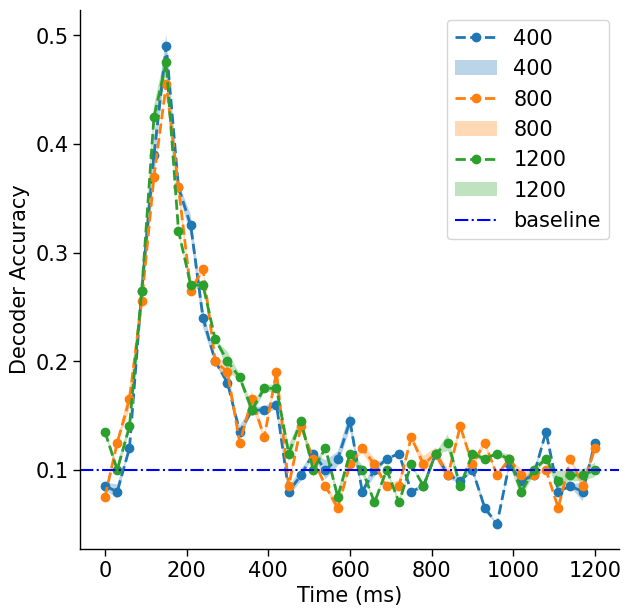

In [82]:

times = generate_times(0, 1200, 30)
fig, ax = plt.subplots(figsize=(7, 7))

for delay in [400, 800, 1200]:
    decoder_results = np.load(f"decoding_accuracy_{delay}ms.npy")
    mean = decoder_results.mean(axis=1) #
    sd = decoder_results.std(axis=1, ddof=1)
    se = sd / np.sqrt(len(mean))

    # Plot mean response
    ax.plot(times, mean, linewidth=2, label=f"{delay}", marker="o", linestyle="--")
    
    # Add SE as a shaded region
    ax.fill_between(times, mean - se, mean + se, alpha=0.3, label=f"{delay}")

# Add vertical dashed lines at 60ms and 180ms
# ax.axvline(x=60, linestyle="-.", color="green", linewidth=1.5, label="Event at 60ms")
# ax.axvline(x=180, linestyle="-.", color="green", linewidth=1.5, label="Event at 180ms")

# Set baseline
ax.axhline(y=0.1, linestyle="-.", color="b", linewidth=1.5, label="baseline")

make_a_plot_beautiful(ax)

# Labels and legend
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.legend()

plt.show()